In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [2]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

# selectivity theory with various target population

In [5]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], KPS=lambda KPN: 1000, area3Dto1D=[10], 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6, lengthScale=scale
)

In [6]:
def theta_DNA(parm):
    equi = numericSolver(parm, rxnNonly, labelsNonly, ifprint=False)
    theta = num.calc_BoundRatio_modelA(parm=parm.iloc[0], equi=equi.iloc[0])
    return theta

def theta_singleS(parm):
    equi = numericSolver(parm, rxnSingleS, labelsSingleS, ifprint=False)
    theta = num.calc_BoundRatio_modelB(parm=parm.iloc[0], equi=equi.iloc[0])
    return theta

def theta_doubleS(parm):
    equi = numericSolver(parm, rxnDoubleS, labelsDoubleS, ifprint=False)
    theta = num.calc_BoundRatio_modelC(parm=parm.iloc[0], equi=equi.iloc[0])
    return theta

def freeProDiff(NP1, model1, model2, pop1, pop2, Ntot = 2, KPP = 1e6, NS = 2, scale = 2):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1]) / pop1
    else:
        N1 = NP1 / pop1
    N2 = (Ntot - N1*pop1) / pop2
    if N1[0] < 1e-9:
        parm2 = GenParms(N2, NS, scale, KPP)
        theta2 = model2(parm2)
        return -(N2*(1-theta2))[0]
    elif N2[0] < 1e-9:
        parm1 = GenParms(N1, NS, scale, KPP)
        theta1 = model1(parm1)
        return (N1*(1-theta1))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(N2, NS, scale, KPP)
        theta1 = model1(parm1)
        theta2 = model2(parm2)
        return (N1*(1-theta1) - N2*(1-theta2))[0]
    
def pBoundRatios(NP1, model1, model2, pop1, pop2, Ntot = 2, KPP = 1e6, NS = 2, scale = 2):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1]) / pop1
    else:
        N1 = NP1 / pop1
    N2 = (Ntot - N1*pop1) / pop2
    if N1[0] < 1e-9:
        parm2 = GenParms(N2, NS, scale, KPP)
        theta2 = model2(parm2)
        return 0, theta2
    elif N2[0] < 1e-9:
        parm1 = GenParms(N1, NS, scale, KPP)
        theta1 = model1(parm1)
        return theta1, 0
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(N2, NS, scale, KPP)
        theta1 = model1(parm1)
        theta2 = model2(parm2)
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, pop1, pop2, theta1, theta2):
    return theta1*(N1/pop1), theta2*(Ntot - N1)/pop2

## Whether selectivity remains considering populations

In [67]:
KPPList = 10.0**np.arange(-1,6.01,0.5)
clustered_onDNA = []
separated_onDNA = []
root_list = []
pop1 = 10
pop2 = 1
for i, Ptot in enumerate([8]):
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        r_dimer = root_scalar(
            freeProDiff, x0=Ptot/2, x1=0, xtol=1e-12, 
            args=(theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
        )
        root_list.append(r_dimer.root)
        th1, th2 = pBoundRatios(r_dimer.root, theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
        spr, cls = proteinsOnDNA(r_dimer.root, Ptot, pop1, pop2, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)

100% (15 of 15) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


##############
In our DNA+clusTarg model, P + S2 -> PS2 costs all the targets. 
Therefore, for monomers, single-target sites are preferred.
##############


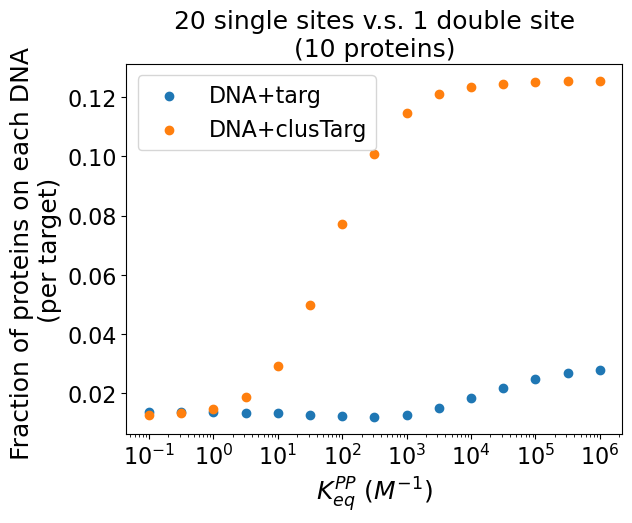

In [69]:
print('##############')
print('''In our DNA+clusTarg model, P + S2 -> PS2 costs all the targets. 
Therefore, for monomers, single-target sites are preferred.''')
print('##############')

plt.scatter(KPPList, separated_onDNA[0]/2/8, label='DNA+targ')
plt.scatter(KPPList, clustered_onDNA[0]/2/8, label='DNA+clusTarg')

plt.semilogx()
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('20 single sites v.s. 1 double site\n(10 proteins)', fontsize=18)
plt.xlabel('$K_{eq}^{PP}$ ($M^{-1}$)', fontsize=18)
plt.ylabel('Fraction of proteins on each DNA \n(per target)', fontsize=18)
plt.show()

## how selectivity changes when population changes

In [24]:
pop1List = np.arange(1,10.5,2)
ptotList = pop1List*2 + 2
pop1 = 10
pop2 = 1
kpp = 1e4

In [25]:
clustered_onDNA = []
separated_onDNA = []
for i, pop1 in enumerate(progressbar(pop1List)):
    Ptot = ptotList[i]
    spr_n = []
    cls_n = []
    r_dimer = root_scalar(
        freeProDiff, x0=Ptot/2, x1=0, xtol=1e-12, 
        args=(theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    )
    th1, th2 = pBoundRatios(r_dimer.root, theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    spr, cls = proteinsOnDNA(r_dimer.root, Ptot, pop1, pop2, th1, th2)
    clustered_onDNA.append(cls)
    separated_onDNA.append(spr)
clustered_onDNA_changeP = np.array(clustered_onDNA)
separated_onDNA_changeP = np.array(separated_onDNA)

100% (5 of 5) |##########################| Elapsed Time: 0:00:16 Time:  0:00:16


In [26]:
clustered_onDNA = []
separated_onDNA = []
for i, pop1 in enumerate(progressbar(pop1List)):
    Ptot = ptotList[i]*2
    spr_n = []
    cls_n = []
    r_dimer = root_scalar(
        freeProDiff, x0=Ptot/2, x1=0, xtol=1e-12, 
        args=(theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    )
    th1, th2 = pBoundRatios(r_dimer.root, theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    spr, cls = proteinsOnDNA(r_dimer.root, Ptot, pop1, pop2, th1, th2)
    clustered_onDNA.append(cls)
    separated_onDNA.append(spr)
clustered_onDNA_P2S = np.array(clustered_onDNA)
separated_onDNA_P2S = np.array(separated_onDNA)

100% (5 of 5) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


In [27]:
clustered_onDNA = []
separated_onDNA = []
root_list = []
for i, pop1 in enumerate(progressbar(pop1List)):
    Ptot = 10
    spr_n = []
    cls_n = []
    r_dimer = root_scalar(
        freeProDiff, x0=Ptot/2, x1=0, xtol=1e-12, 
        args=(theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    )
    root_list.append(r_dimer.root)
    th1, th2 = pBoundRatios(r_dimer.root, theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    spr, cls = proteinsOnDNA(r_dimer.root, Ptot, pop1, pop2, th1, th2)
    clustered_onDNA.append(cls)
    separated_onDNA.append(spr)
clustered_onDNA_sameP = np.array(clustered_onDNA)
separated_onDNA_sameP = np.array(separated_onDNA)

100% (5 of 5) |##########################| Elapsed Time: 0:00:16 Time:  0:00:16


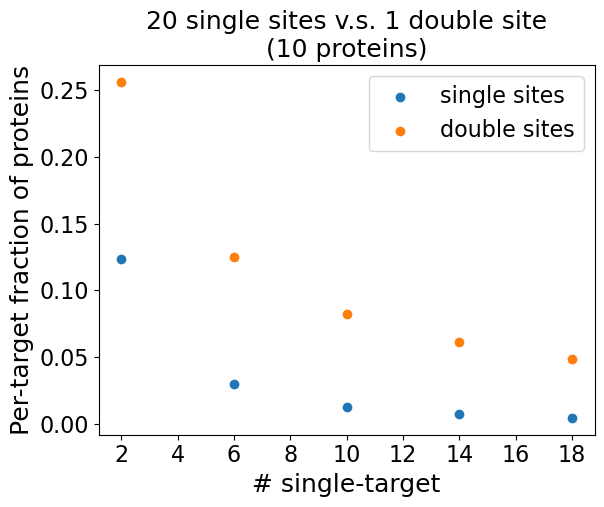

In [42]:
# plt.scatter(pop1List*2, separated_onDNA_changeP/2/ptotList, label='DNA+targ')
# plt.scatter(pop1List*2, clustered_onDNA_changeP/2/ptotList, label='DNA+clusTarg')

plt.scatter(pop1List*2, separated_onDNA_sameP/2/ptotList, label='single sites')
plt.scatter(pop1List*2, clustered_onDNA_sameP/2/ptotList, label='double sites')
# plt.semilogy()

# plt.plot(
#     pop1List*2, clustered_onDNA_sameP/separated_onDNA_sameP, 
#     label='$P_{tot}$=10', lw=2,
# )
# plt.plot(
#     pop1List*2, clustered_onDNA_changeP/separated_onDNA_changeP, 
#     label='$P_{tot}$=$S_{tot}$', lw=2,
# )
# plt.plot(
#     pop1List*2, clustered_onDNA_P2S/separated_onDNA_P2S, 
#     label='$P_{tot}$=2$S_{tot}$', lw=2,
# )

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('20 single sites v.s. 1 double site\n(10 proteins)', fontsize=18)
plt.xlabel('# single-target', fontsize=18)
plt.ylabel('Per-target fraction of proteins', fontsize=18)
# plt.ylabel('Selectivity for double targets', fontsize=18)
plt.show()

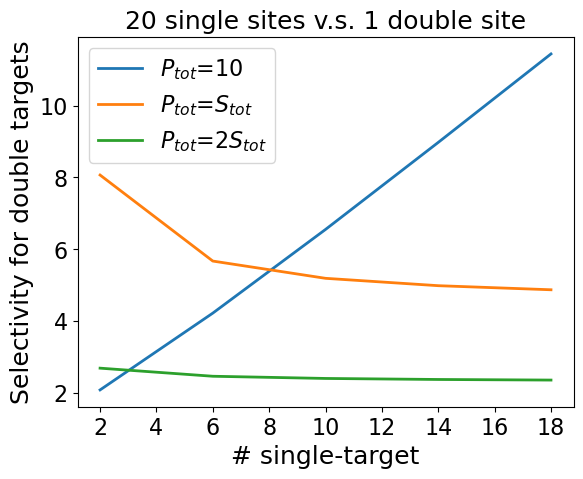

In [35]:
plt.plot(
    pop1List*2, clustered_onDNA_sameP/separated_onDNA_sameP, 
    label='$P_{tot}$=10', lw=2,
)
plt.plot(
    pop1List*2, clustered_onDNA_changeP/separated_onDNA_changeP, 
    label='$P_{tot}$=$S_{tot}$', lw=2,
)
plt.plot(
    pop1List*2, clustered_onDNA_P2S/separated_onDNA_P2S, 
    label='$P_{tot}$=2$S_{tot}$', lw=2,
)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('20 single sites v.s. 1 double site', fontsize=18)
plt.xlabel('# single-target', fontsize=18)
# plt.ylabel('Per-target fraction of proteins', fontsize=18)
plt.ylabel('Selectivity for double targets', fontsize=18)
plt.show()

# Selectivity theory v.s. NERDSS

In [44]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale, 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6
)

In [45]:
parms = GenParms([2,4], 2, 2, 10)

In [73]:
# parms['kaPP'].unique()*0.6022 / 1e6
# parms['kbPP'].unique()
# parms['KPP'].unique()*0.6022
# parms['CP0'].unique() / 0.6022 * 1e6
# parms['kaPN'].unique()*0.6022
# parms['kbPN'].unique()
# parms['KPN'].unique()*0.6022
# parms['CN0'].unique() / 0.6022 * 1e6
# parms['kaPS'].unique()*0.6022
# parms['kbPS'].unique()
# parms['KPS'].unique()*0.6022
# parms['CS0'].unique() / 0.6022 * 1e6
parms['gamma'].unique()

array([100.])

In [44]:
def freeProDiff(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return -((Ntot-N1)*(1-theta2))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return (N1*(1-theta1) - (Ntot-N1)*(1-theta2))[0]
    
def pBoundRatios(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return 0, theta2
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, theta1, theta2):
    return theta1*(N1), theta2*(Ntot - N1)

In [10]:
KPPList = 10.0**np.arange(0,7.01,0.25)
clustered_onDNA = []
separated_onDNA = []
for i, Ptot in enumerate([2, 4]):
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        r_dimer = root_scalar(freeProDiff, x0=Ptot/2, x1=Ptot/2*0.9, xtol=1e-6, args=(Ptot, 2, 2, kpp))
        th1, th2 = pBoundRatios(r_dimer.root, Ptot, 2, 2, kpp)
        spr, cls = proteinsOnDNA(r_dimer.root, Ptot, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)

100% (29 of 29) |########################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (29 of 29) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


In [11]:
# NERDSS results
slcList_repeats_2pro = [[0.7846134133371219, 1.1148256877425806, 3.226054260749391, 29.900123663086855, 189.86720995670993, 328.83102380952386, 716.3366904761904], 
                        [0.08059040750221995, 0.1138934291917021, 0.3452691124787163, 5.3201632313452265, 137.15285469713717, 249.43847606756407, 319.90795991151896]]
slcList_repeats_4pro =  [[0.7839380458445123, 1.608361702731444, 2.4142460159166124, 3.017057706286011, 2.75540309837026, 2.2933347821954073, 3.4153309304606063], 
                         [0.06433321086749408, 0.12193825141052676, 0.15954401742176008, 0.21645287528201054, 0.12229826213536317, 0.09116039107861558, 0.14586540127521788]]
slcList_repeats = [slcList_repeats_2pro, slcList_repeats_4pro]

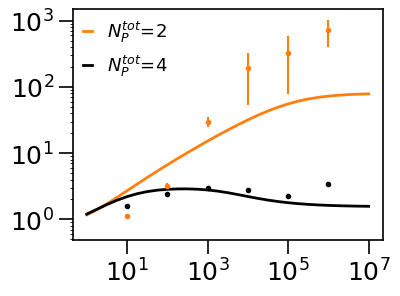

In [12]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
for i, slcRepeat in enumerate(slcList_repeats):
    plt.errorbar(
        np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
        slcRepeat[0], slcRepeat[1], 
        ls='', color=colors[i], marker='.', #edgecolors='black', alpha=alphas[1], 
    )
    
for i, ntot in enumerate([2, 4]):
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Selectivity - NERDSS spatial

see Rockfish under folder twosegments

# Four DNA segments

In [6]:
# results from NERDSS simulations
targetCluster = np.array([1, 2, 3, 4])

## Proteins can form dimers

In [26]:
DNApartition_2 = ([0.        , 0.1932004 , 0.34046152, 0.43666561],
                 [0.        , 0.03428115, 0.02344495, 0.03153427])

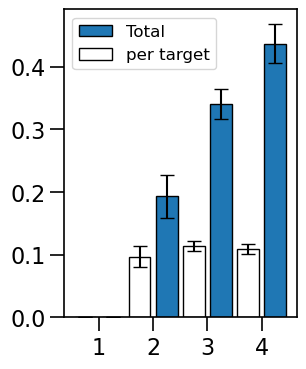

In [31]:
plt.figure(figsize=(3,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_2[0], yerr=DNApartition_2[1],
    capsize=5, edgecolor='black', facecolor='tab:blue', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_2[0]/targetCluster, 
    yerr=DNApartition_2[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

# plt.plot(
#     targetCluster, DNAbound_2/NP_tot_2, color='tab:blue', 
#     marker='^', ls='-', label='dimer'
# )
# plt.plot(
#     targetCluster, DNAbound_2/NP_tot_2/targetCluster, 
#     color='tab:blue', marker='^', ls='--', markerfacecolor='none',
# )

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## monomer

In [39]:
DNApartition_1 = ([0.01963284, 0.04229797, 0.07063262, 0.0853417],
                 [0.00603037, 0.00844562, 0.00908131, 0.01204614])

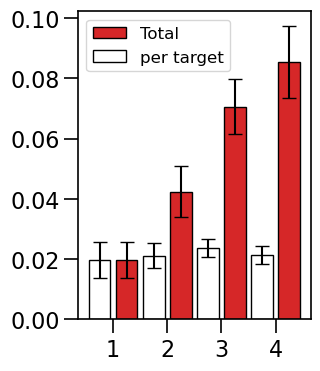

In [40]:
plt.figure(figsize=(3,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_1[0], yerr=DNApartition_1[1],
    capsize=5, edgecolor='black', facecolor='tab:red', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_1[0]/targetCluster, 
    yerr=DNApartition_1[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

# plt.plot(
#     targetCluster, DNAbound_1/NP_tot_1, color='tab:blue', 
#     marker='^', ls='-', label='monomer'
# )
# plt.plot(
#     targetCluster, DNAbound_1/NP_tot_1/targetCluster, 
#     color='tab:red', marker='^', ls='--', markerfacecolor='none',
# )

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## Linear tetramer

In [37]:
DNApartition_4 = ([0. , 0.08206282, 0.30460399, 0.54261452],
                 [0. , 0.02781052, 0.0716499 , 0.09244663])

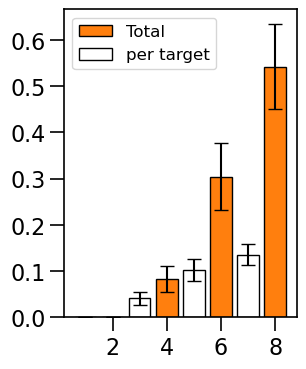

In [38]:
plt.figure(figsize=(3,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_4[0], yerr=DNApartition_4[1],
    capsize=5, edgecolor='black', facecolor='tab:orange', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_4[0]/targetCluster, 
    yerr=DNApartition_4[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)
    
# plt.plot(
#     targetCluster, DNAbound_4/NP_tot_4, color='tab:orange', 
#     marker='o', ls='-', label='tetramer'
# )
# plt.plot(
#     targetCluster, DNAbound_4/NP_tot_4/targetCluster, 
#     color='tab:orange', marker='o', ls='--', markerfacecolor='none',
# )

plt.legend(fontsize=12)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()